<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [5]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(0.0001)))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))



    # tf.keras.layers.Flatten(input_shape=(28, 28)), , kernel_regularizer=regularizers.l2(0.001)
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(10)


In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images, train_labels, epochs=20, batch_size=512, validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/20
118/118 [==============================] - 2s 12ms/step - loss: 0.7437 - accuracy: 0.7600 - val_loss: 0.5512 - val_accuracy: 0.8163
Epoch 2/20
118/118 [==============================] - 1s 10ms/step - loss: 0.4906 - accuracy: 0.8408 - val_loss: 0.4918 - val_accuracy: 0.8370
Epoch 3/20
118/118 [==============================] - 1s 9ms/step - loss: 0.4510 - accuracy: 0.8530 - val_loss: 0.4904 - val_accuracy: 0.8322
Epoch 4/20
118/118 [==============================] - 1s 10ms/step - loss: 0.4222 - accuracy: 0.8605 - val_loss: 0.4491 - val_accuracy: 0.8504
Epoch 5/20
118/118 [==============================] - 1s 12ms/step - loss: 0.4024 - accuracy: 0.8674 - val_loss: 0.4307 - val_accuracy: 0.8554
Epoch 6/20
118/118 [==============================] - 1s 12ms/step - loss: 0.3853 - accuracy: 0.8729 - val_loss: 0.4372 - val_accuracy: 0.8562
Epoch 7/20
118/118 [==============================] - 1s 11ms/step - loss: 0.3761 - accuracy: 0.8763 - val_loss: 0.4145 - val_accuracy: 0.8626


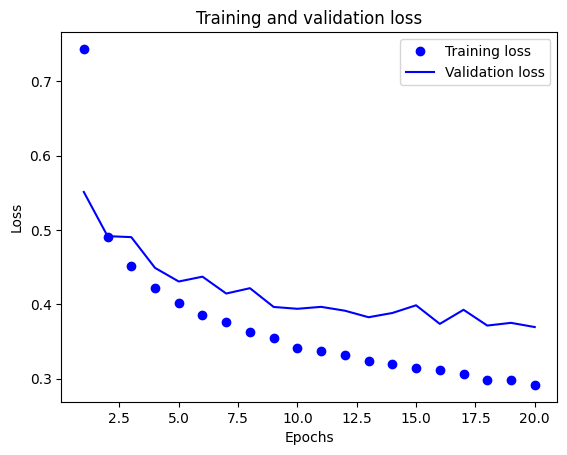

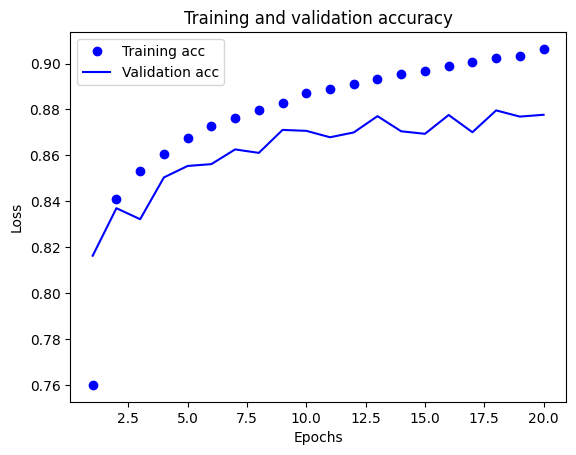

In [8]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [9]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [10]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


In [11]:
predictions[0]

array([4.0831401e-06, 1.2643534e-07, 1.1125355e-05, 2.7753479e-06,
       5.2180599e-06, 1.9334575e-02, 3.9513607e-06, 2.0166697e-02,
       5.6175637e-04, 9.5990980e-01], dtype=float32)